In [1]:
import os
import sys
sys.path.append('..')

import lzma
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as se
se.set_style('white')
se.set_context('poster')

import pyquery
from ipywidgets import FloatProgress
from IPython.display import display

from config import settings
import utils
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


import string
import random
import time
import binascii 

In [2]:
cases_format="json"
#else "xml"
#cases_format="xml"
compressed_file = utils.get_cases_from_bulk(jurisdiction="New Mexico", data_format=cases_format)

downloading New Mexico-20200302-text.zip into ../data dir


66568it [00:19, 3404.29it/s]

extracting New Mexico-20200302-text.zip into ../data dir
Done.


In [4]:
#a list to hold the cases we're sampling
cases = []

#decompress the file line by line
with lzma.open(compressed_file) as infile:
    for line in infile:
        #decode the file into a convenient format
        record = json.loads(str(line, 'utf-8'))
        #if the decision date on the case matches one we're interested in, add to our list
        cases.append(record)

print("Selected jurisdiction: New Mexico")
print("Number of Cases: ", len(cases))

Selected jurisdiction: New Mexico
Number of Cases:  18338


In [5]:
def parse_json(case):
    feat_dict = {}
    feat_dict["case_id"] = case['id']
    #feat_dict["case_url"] = case['url']
    feat_dict["case_name"] = case['name']
    feat_dict["case_name_abbreviation"] = case['name_abbreviation']
    feat_dict["date"] = case['decision_date']
    feat_dict["year"] = int(case['decision_date'][:4])
    feat_dict["citations"] = [citation for citation in case['citations'] if citation['type'] == 'official'][0]
    #feat_dict["volume"] = case['volume']
    feat_dict["court"] = case['court']['name']
    feat_dict["opinion_count"] = len(case['casebody']['data']['opinions'])
    feat_dict["jurisdiction"] = case['jurisdiction']#['name_long']
    #feat_dict["name"] = case['jurisdiction']['name']
    feat_dict["judges"]=case["casebody"]["data"]["judges"]
    feat_dict["attorneys"]=case["casebody"]["data"]["attorneys"]
    feat_dict["author"]=case["casebody"]["data"]["opinions"][0]["author"]

    #Main text: opinions
    feat_dict["opinion"]=case["casebody"]["data"]["opinions"][0]["text"]

    return feat_dict

In [6]:
#Add progress bar
bar = FloatProgress(min=0, max=len(cases))
display(bar)

#For each file, parse with parse_xml() and add to list of parsed files
parsed_files = []
for case in cases:
    doc = parse_json(case) #json
    #doc = ET_parse_xml(case) #xml
    parsed_files.append(doc)
    bar.value += 1

FloatProgress(value=0.0, max=18338.0)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
raw_df = pd.DataFrame(parsed_files)
#raw_df.head()

# Extract documents by an author

## Shingling: *shingles and hashing shingles*

N-gram for a selected author (or all cases). 

Shingling: convert documents to sets. 
Shingle function: clean and split each text file into a set of K-shingles

In [9]:
#pre-processing
import nltk
from nltk.corpus import stopwords
import string
import re

# Download the necessary resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


def pre_process(text):
    # Lowercase
    lower_text = text.lower()
    # Remove numbers
    remove_numbers = re.sub(r'\d+', '', lower_text)
    # Remove punctuation
    remove_hyphen = remove_numbers.replace('-', '')
    remove_symbol = remove_hyphen.replace('¶', '')    
    remove_symbol1 = remove_symbol.replace('§', '')
    remove_apostrophes = remove_symbol1.replace("’", '')    
    remove_apostrophes1 = remove_apostrophes.replace('“', '')
    remove_apostrophes2 = remove_apostrophes1.replace('”', '')
    remove_punctuation = remove_apostrophes2.translate(str.maketrans("", "", string.punctuation))
    # Remove stopwords
    #for word in stopwords.words("english"):
    #    remove_punctuation = remove_punctuation.replace(' '+word+' ', ' ')
    # split text into words
    remove_punctuation = re.sub("[^\w]", " ", remove_punctuation).split()
    return remove_punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ashleydeglinnocenti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ashleydeglinnocenti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ashleydeglinnocenti/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
authors_cases_dict = {}


for index, row in raw_df.iterrows():
    case_id = row['case_id']
    author = row['author']
    if row['author'] and "curiam" not in row['author']:
        author = row['author']
        author = [a.strip() for a in author.split(',')][0]
        author = [a.strip() for a in author.split('.')][0]
        author = [a.strip() for a in author.split(';')][0]
        author = author.upper()
        if "curiam" in author.lower():
            author = 'PER CURIAM'

    if author in authors_cases_dict:
        authors_cases_dict[author].append(case_id)
    else:
        authors_cases_dict[author] = [case_id]

show_dict=False       
if show_dict:
    for author, case_id in authors_cases_dict.items():
        print(f"Number of Cases: {len(case_id)}")
        print(f"Author: {author}")
        print(f"Case IDs: {case_id}")
        print()

In [9]:
#print(authors_cases_dict[None])

In [11]:
#ALL cases or a selected author: 

author_dict={}
sum_words=0 

#all_cases = True
all_cases = False 


if all_cases: 
    num_cases=len(cases)
    
    #Add progress bar
    bar = FloatProgress(min=0, max=len(cases))
    display(bar)
    
    #creates a dictionary (key, value) = (case id, opinion) for all the cases
    for _, row in raw_df.iterrows():
        case = row['case_id']
        for opinion in raw_df[raw_df["case_id"] == case]["opinion"]:
            sum_words += len(opinion.split())
            author_dict[case]=pre_process(opinion)
        bar.value += 1
    avg_words = sum_words//num_cases
    print(f'Number of cases: {num_cases}')
    print(f'Average words in an opinion: {avg_words}')
else: 
    #some prolific authors are SUTIN, WOOD, MINZNER, HENDLEY, COMPTON, PER CURIAM, None 
    author_ngram="WOOD"
    num_cases=len(authors_cases_dict[author_ngram])
    
    #creates a dictionary (key, value) = (case id, opinion) for the selected author  

    for case in authors_cases_dict[author_ngram]:
        for opinion in raw_df[raw_df["case_id"] == case]["opinion"]:
            sum_words += len(opinion.split())
            author_dict[case]=pre_process(opinion)
    avg_words = sum_words//num_cases
    print(f'Cases by judge {author_ngram}: {num_cases}')
    print(f'Average words in an opinion by judge {author_ngram}: {avg_words}')



Cases by judge WOOD: 933
Average words in an opinion by judge WOOD: 1699


In [12]:
#example of a random case after pre-processing 
import random
sample_ID, sample_opinion = random.choice(list(author_dict.items()))

opinion1 = list(raw_df[raw_df['case_id'] == sample_ID]['opinion'])

print("\033[1m" + "Opinion before pre-processing:" + "\033[0m")
print(opinion1)

print("\n\033[1mOpinion after pre-processing\033[0m:")
print('Case ID: ', sample_ID, '\n', sample_opinion)
#print('Case ID: ', sample_ID, '\n', sample_opinion[:20], '\n... ETC ...')

Opinion before pre-processing:
['OPINION\nWOOD, Chief Judge.\nDefendant shoplifted a combination radio and tape deck. He was convicted of shoplifting merchandise valued at more than $100.00 but not more than $2,500.00. Defendant challenges both the evidence and the instruction concerning value.\nThe evidence is that the retail price of the merchandise was $119.97 and the wholesale price was $84.97. If the retail price is sufficient evidence of value, the crime was a fourth degree felony. If the wholesale price is the value evidence to be considered, the crime is a petty misdemean- or. Section 40A-16-20(B), N.M.S.A.1953 (2d Repl.Vol. 6).\nOur property crime statutes do not state how value is to be determined. As examples, see §§ 40A-16-1, 40A-16-6, 40A-16-7, 40A-16-11, N.M.S.A.1953 (2d Repl.Vol. 6). The decisions have used the term “market value” as the test. See State v. Gallegos, 63 N.M. 57, 312 P.2d 1067 (1957) and committee commentary to U.J.I.Crim. 16.01. The trial court instructed

# Shingling 

Convert documents to sets of shingles. This is a way to account for ordering of words in a document. For this application we consider words as tokens.  

We use a hash function (CRC32) that maps the string to a bucket number of 2^32. The CRC32 (Cyclic Redundancy Check 32-bit) algorithm is a widely used hashing algorithm that produces a 32-bit hash value from an input string. 

In [13]:
#Select a value for k 
shingle_size = 5

print(f'Shingle size is {shingle_size}.')

Shingle size is 5.


In [14]:
d = author_dict
t = {}

docsAsShingleSets = {}
docsAsShingleWSets = {}
caseIDs = []
totalShingles = 0
shingleNo = 0
t0 = time.time()

# loop through all the documents
for i in d.keys(): 
    
    #Retrieve opinion and case ID 
    words = d[i]
    caseID = i

    # Maintain a list of all case IDs.
    caseIDs.append(caseID)

    # 'shinglesInDoc' will hold all of the unique shingles present in the
    # current document. If a shingle ID occurs multiple times in the document,
    # it will only appear once in the set.

    # keep word shingles
    shinglesInDocWords = set()

    # keep hashed shingles
    shinglesInDocInts = set()

    shingle = []
    # For each word in the document...
    for index in range(len(words) - shingle_size + 1):
        # Construct the shingle text by combining k words together.
        shingle = words[index:index + shingle_size]
        shingle = ' '.join(shingle)

        # Hash the shingle to a 32-bit integer.
        crc = binascii.crc32(shingle.encode()) & 0xffffffff
        #& 0xffffffff is used to ensure that you get the same numeric value across all Python versions and platforms

        #Add the shingle to the set of shingles
        if shingle not in shinglesInDocWords:
            shinglesInDocWords.add(shingle)
            
        # Add the hash value to the set of hashed shingles
        if crc not in shinglesInDocInts:
            shinglesInDocInts.add(crc)
            # Count the number of shingles across all documents.
            shingleNo = shingleNo + 1
    # Store the completed list of shingles for this document in the dictionary.
    docsAsShingleSets[caseID] = shinglesInDocInts
    docsAsShingleWSets[caseID] = shinglesInDocWords

totalShingles = shingleNo

print('Total Number of Shingles', shingleNo)
# Report how long shingling took.
print('\nShingling ', len(docsAsShingleSets), ' docs took', round(time.time() - t0, 2), 'sec.')
print('\nAverage shingles per doc: ',  (shingleNo // len(docsAsShingleSets)))

Total Number of Shingles 1428304

Shingling  933  docs took 1.0 sec.

Average shingles per doc:  1530


In [15]:
if True: 
    print("BEFORE\n")
    sample_ID, sample_opinion = random.choice(list(author_dict.items()))
    opinion1 = list(raw_df[raw_df['case_id'] == sample_ID]['opinion'])
    #print(opinion1)
    print(f'\n\033[1m {shingle_size} words shingles in opinion {sample_ID}\033[0m')
    print(docsAsShingleWSets[sample_ID])
    print()
    print(f'\033[1m {shingle_size} hashed words shingles in opinion {sample_ID}\033[0m')
    print(docsAsShingleSets[sample_ID])

BEFORE


 5 words shingles in opinion 1577349
{'convictions under both of the', 'sufficient evidence to justify a', 'accident from the contents of', 'preserved through a legal conclusion', 'campos nm pd state v', 'statements sufficiency of the evidence', 'however inferences from other evidence', 'independent of the testimony of', 'the purported telephone call was', 'as both mcgee and defendant', 'moss fd th cir united', 'defendant had not worked for', 'entitled to a new trial', 'trier of fact to convict', 'following day mcgee gave ortiz', 'there is no direct evidence', 'route of travel was inaccurate', 'determine whether the record evidence', 'was a fake that he', 'to have defendants wife killed', 'case even if properly admitted', 'william and bill in the', 'of whether the above four', 'of mcgees scheme no the', 'classes mcgee furnished ortiz photographs', 'not worked for about a', 'of defendants wife must be', 'direct proof and is usually', 'a visitor to defendants home', 'because the

In [16]:
show_shingles = True
if show_shingles:
    print("\033[1mTotal shingles:\033[0m ", len(docsAsShingleSets[sample_ID]))
    
    print("\n\033[1mHashed shingles:\033[0m")
    print(docsAsShingleSets[sample_ID])

Total shingles:  1765

Hashed shingles:
{372334594, 985382928, 1037058067, 4032708634, 315719716, 1311252520, 1721319465, 4106043447, 3158597690, 1298415677, 100417599, 3754639427, 267354183, 2174804044, 2497298508, 3528269906, 1294786644, 3725017180, 3372015712, 2673688674, 3576037476, 3451109484, 1032790125, 4246773887, 2369757312, 811860099, 2494840966, 3393167504, 1917386901, 1736384664, 2202747043, 2530590886, 967245991, 4154138793, 2914689196, 2132721839, 3376234673, 2448433330, 3446251699, 1668497588, 2400370882, 4221198532, 1710514377, 1307099337, 4044824788, 2652102868, 1733542117, 4047978728, 2962866410, 2720628973, 3131097325, 861618416, 3229483250, 3886907637, 3724443898, 2701033726, 1818067200, 1144946950, 2952388873, 2517401870, 3931726096, 2867003664, 4096270614, 562766103, 21487901, 1831747870, 1465426209, 2240618786, 3024159014, 3284787497, 2436571438, 1532215598, 2318164270, 4133331250, 4068319539, 2299027765, 263029048, 2314879292, 185377096, 2902819149, 4012835151, 

##      Define Triangle Matrices
Triangle matrices to hold the similarity values. For storing similarities between pairs, we only need roughly half the elements of a full matrix. Using a triangle matrix requires less than half the memory of a full matrix. 

In [17]:
# Calculate the number of elements needed in our triangle matrix
numDocs = len(docsAsShingleSets)
numElems = int(numDocs * (numDocs - 1) / 2)

# Initialize two empty lists to store the similarity values. 
# 'JSim' will be for the actual Jaccard Similarity values. 
# 'estJSim' will be for the estimated Jaccard Similarities found by comparing
# the MinHash signatures.
JSim = [0 for x in range(numElems)]
estJSim = [0 for x in range(numElems)]

# Define a function to map a 2D matrix coordinate into a 1D index.
def getTriangleIndex(i, j):
  # If i == j that's an error.
  if i == j:
    sys.stderr.write("Can't access triangle matrix with i == j")
    sys.exit(1)
  # If j < i just swap the values.
  if j < i:
    temp = i
    i = j
    j = temp
  
  # Calculate the index within the triangular array.
  # This  indexing scheme is taken from pg. 211 of:
  # http://infolab.stanford.edu/~ullman/mmds/ch6.pdf
    k = int(i * (numDocs - (i + 1) / 2.0) + j - i) - 1
  
  return k

##                 Calculate Jaccard Similarities
Calculate all the Jaccard similarities by comparing couple of elements in the sets. This should be slower than the MinHash approach.

In [18]:
new_sim = True
if new_sim: 
    if numDocs <= 2500:
        print("\nCalculating Jaccard Similarities...")

        # Time the calculation.
        t0 = time.time()

        # For every document pair...
        for i in range(0, numDocs):
            # Print progress every 100 documents.
            if (i % 100) == 0:
                print("  (" + str(i) + " / " + str(numDocs) + ")")

            # Retrieve the set of shingles for document i.
            s1 = docsAsShingleSets[caseIDs[i]]

            for j in range(i + 1, numDocs):
                # Retrieve the set of shingles for document j.
                s2 = docsAsShingleSets[caseIDs[j]]
                # Calculate and store the actual Jaccard similarity.
                JSim[getTriangleIndex(i, j)] = (len(s1.intersection(s2)) / len(s1.union(s2)))    

        # Calculate the elapsed time (in seconds)
        elapsed = (time.time() - t0)

        print("\nCalculating all Jaccard Similarities took %.2fsec" % elapsed)

# Delete the Jaccard Similarities, since it's a pretty big matrix.   
#del JSim


Calculating Jaccard Similarities...
  (0 / 933)
  (100 / 933)
  (200 / 933)
  (300 / 933)
  (400 / 933)
  (500 / 933)
  (600 / 933)
  (700 / 933)
  (800 / 933)
  (900 / 933)

Calculating all Jaccard Similarities took 32.71sec


In [20]:
print("Len of Jsim: ", len(JSim))
print("Number of couples: ", num_cases* (num_cases-1)/2)

Len of Jsim:  434778
Number of couples:  434778.0


## Save or load file

In [19]:
#print(type(JSim))
#print(type(JSim[0])

#if all_cases:
    #print('New matrix')
    #np.save('jaccard_similarity_with_stop_words.npy', JSim)
    #np.save('jaccard_similarity_without_stop_words.npy', JSim)

In [20]:
#if all_cases:
 #   JSim = np.load('jaccard_similarity_with_stop_words.npy').tolist()
    #JSim = np.load('jaccard_similarity_without_stop_words.npy').tolist()
  #  print(type(JSim))
   # print(type(JSim[0]))

##  Generate MinHash Signatures

In [21]:
# Time this step.
t0 = time.time()

print('\nGenerating random hash functions...')
numHashes = 100

# Record the maximum shingle ID that we assigned.
maxShingleID = 2**32-1

# We need the next largest prime number above 'maxShingleID'.
nextPrime = 4294967311


# Our random hash function will take the form of:
#   h(x) = (a*x + b) % c
# Where 'x' is the input value, 'a' and 'b' are random coefficients, and 'c' is
# a prime number just greater than maxShingleID.

# Generate a list of 'k' random coefficients for the random hash functions,
# while ensuring that the same value does not appear multiple times in the list.

def pickRandomCoeffs(k):
    # Create a list of 'k' random values.
    randList = []
    
    while k > 0:
        # Get a random shingle ID.
        randIndex = random.randint(0, maxShingleID) 
        
        # Ensure that each random number is unique.
        while randIndex in randList:
            randIndex = random.randint(0, maxShingleID) 
            
        # Add the random number to the list.
        randList.append(randIndex)
        k = k - 1
        
    return randList

# For each of the 'numHashes' hash functions, generate a different coefficient 'a' and 'b'.   
coeffA = pickRandomCoeffs(numHashes)
coeffB = pickRandomCoeffs(numHashes)


print('\nGenerating MinHash signatures for all documents...')

# List of documents represented as signature vectors
signatures = []

#Add progress bar
bar = FloatProgress(min=0, max=len(cases))
display(bar)

# For each document...
for docID in caseIDs:
    
    # Get the shingle set for this document.
    shingleIDSet = docsAsShingleSets[docID]
    
    # The resulting minhash signature for this document. 
    signature = []
    
    # For each of the random hash functions...
    for i in range(0, numHashes):
        
        # For each of the shingles actually in the document, calculate its hash code
        # using hash function 'i'. 

        # Track the lowest hash ID seen. Initialize 'minHashCode' to be greater than
        # the maximum possible value output by the hash.
        minHashCode = nextPrime + 1

        # For each shingle in the document...
        for shingleID in shingleIDSet:
            # Evaluate the hash function.
            hashCode = (coeffA[i] * shingleID + coeffB[i]) % nextPrime 

            # Track the lowest hash code seen.
            if hashCode < minHashCode:
                minHashCode = hashCode

        # Add the smallest hash code value as component number 'i' of the signature.
        signature.append(minHashCode)
    # Store the MinHash signature for this document.
    signatures.append(signature)
    bar.value += 1

# Calculate the elapsed time (in seconds)
elapsed = (time.time() - t0)
        
print("\nGenerating MinHash signatures took %.2fsec" % elapsed)


Generating random hash functions...

Generating MinHash signatures for all documents...


FloatProgress(value=0.0, max=18338.0)


Generating MinHash signatures took 36.01sec


In [23]:
print("\033[1mSignature of the first document:\033[0m")
print(signatures[0])
print("\nSignature has lenght ", len(signatures[0]))

Signature of the first document:
[2617408, 4260810, 2459392, 495647, 5568754, 200308, 544528, 4339205, 11358356, 643611, 2925007, 100972, 6962333, 3458930, 37612, 2436217, 7208287, 1765877, 2281741, 5369086, 1193066, 818937, 4023631, 12066037, 2468644, 3920584, 4116980, 6439891, 7417755, 12739340, 4709003, 1360073, 3605180, 6839279, 740028, 752282, 2228647, 3736551, 99154, 11540380, 8480782, 11879773, 2150056, 352319, 2790131, 254473, 1241679, 10493843, 9211259, 12345937, 6787982, 293884, 3785316, 4640950, 1213429, 1921299, 2452925, 974634, 5595953, 6354648, 1635741, 6259269, 2630244, 3436326, 742062, 5190760, 8960857, 68207, 1098884, 2448951, 965150, 5248234, 722807, 3996783, 4054538, 3704940, 4847395, 1367289, 2546571, 857789, 368643, 194799, 7785102, 2465208, 599882, 4284802, 1676459, 166389, 450255, 2664411, 1336921, 12781878, 763148, 4797089, 1644386, 2827726, 1509272, 1506553, 3004222, 5143348]

Signature has lenght  100


## Compare All Signatures

In [24]:
print('\nComparing all signatures...')

#Add progress bar
bar = FloatProgress(min=0, max=len(cases))
display(bar)

# Time this step.
t0 = time.time()

# For each of the test documents...
for i in range(0, numDocs):
    # Get the MinHash signature for document i.
    signature1 = signatures[i]
    
    # For each of the other test documents...
    for j in range(i + 1, numDocs):        
        # Get the MinHash signature for document j.
        signature2 = signatures[j]    
        count = 0
        # Count the number of positions in the minhash signature which are equal.
        for k in range(0, numHashes):
            count = count + (signature1[k] == signature2[k])
            
        # Record the percentage of positions which matched.    
        estJSim[getTriangleIndex(i, j)] = (count / numHashes)
    
    bar.value += 1

# Calculate the elapsed time (in seconds)
elapsed = (time.time() - t0)
        
print("\nComparing MinHash signatures took %.2fsec" % elapsed)

#print(estJSim)


Comparing all signatures...


FloatProgress(value=0.0, max=18338.0)


Comparing MinHash signatures took 4.75sec


In [30]:
print(f'There are {len(JSim)} similarity values\n')
print("Max value in JSim: ", max(JSim))
print("Max value in estJSim:", max(estJSim))
#index_max = max(range(len(JSim)), key=JSim.__getitem__)
#print(index_max)

There are 434778 similarity values

Max value in JSim:  0.11919831223628692
Max value in estJSim: 0.13


In [26]:
from statistics import mean

print("Mean value in JSim: ", mean(JSim))
print("Mean value in estJSim: ", mean(estJSim))

Mean value in JSim:  0.0010620983247452299
Mean value in estJSim:  0.0011883075960605182


In [28]:
from statistics import mode 

print("Mode of data in JSim: ", mode(JSim))
print("Mode of data in estJSim: ", mode(estJSim))

Mode of data in JSim:  0.0
Mode of data in estJSim:  0.0


## Display Similar Document Pairs


There are 933 documents.

There are 434778 similarity values.


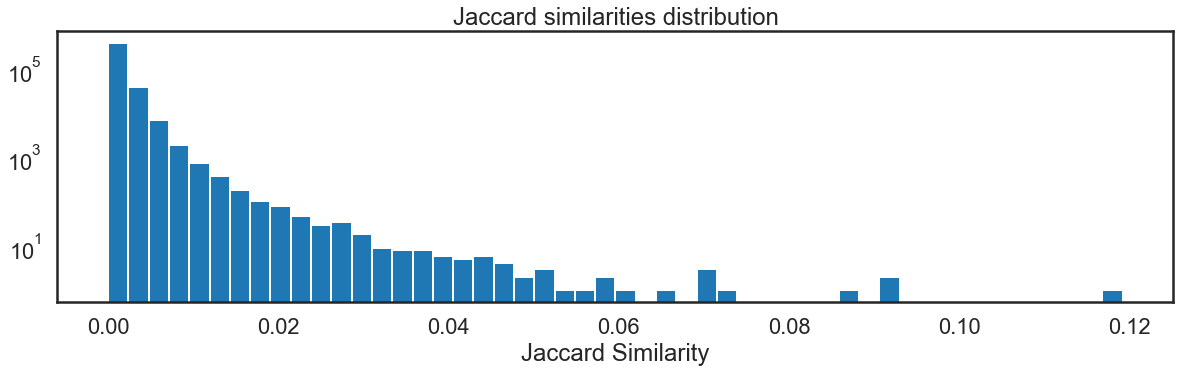

In [36]:
# creating the bar plot
print(f'\nThere are {numDocs} documents.')
print(f'\nThere are {len(JSim)} similarity values.')
fig = plt.figure(figsize = (20, 5))
plt.hist(JSim, bins=50, log=True)
plt.xlabel('Jaccard Similarity')
#plt.ylabel('')
plt.title('Jaccard similarities distribution')
plt.show()


There are 933 documents.

There are 434778 similarity values.


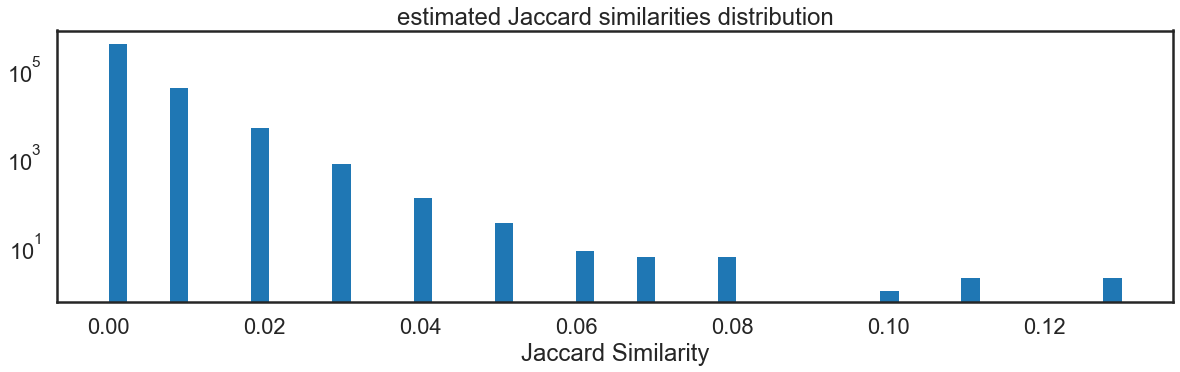

In [35]:
# creating the bar plot
print(f'\nThere are {numDocs} documents.')
print(f'\nThere are {len(JSim)} similarity values.')
fig = plt.figure(figsize = (20, 5))
plt.hist(estJSim, bins=50, log=True)
plt.xlabel('Jaccard Similarity')
#plt.ylabel('')
plt.title('estimated Jaccard similarities distribution')
plt.show()

In [43]:
threshold = 0.05
print("\nList of Document Pairs with J(d1,d2) more than", threshold)
print("Values shown are the estimated Jaccard similarity and the actual")
print("Jaccard similarity.\n")
print("                               Est. J      Act. J")

# Time this step.
t0 = time.time() 

index_i = []
index_j = []

# For each of the document pairs...
for i in range(0, numDocs):  
    for j in range(i + 1, numDocs):
        # Retrieve the estimated similarity value for this pair.
        J = JSim[getTriangleIndex(i, j)]
        estJ = estJSim[getTriangleIndex(i, j)]
        
        # If the similarity is above the threshold...
        if estJ > threshold:            
            # Calculate the actual Jaccard similarity for validation.
            s1 = docsAsShingleSets[caseIDs[i]]
            s2 = docsAsShingleSets[caseIDs[j]]
            J = (len(s1.intersection(s2)) / len(s1.union(s2)))
            index_i.append(i)
            index_j.append(j)
            
            # Print out the match and similarity values with pretty spacing.
            print("  %10s --> %10s   %.5f     %.5f" % (caseIDs[i], caseIDs[j], estJ, J))
            
# Calculate the elapsed time (in seconds)
elapsed = (time.time() - t0)


List of Document Pairs with J(d1,d2) more than 0.05
Values shown are the estimated Jaccard similarity and the actual
Jaccard similarity.

                               Est. J      Act. J
     1557084 -->    1571038   0.07000     0.07055
     1573053 -->    2764068   0.07000     0.07308
     1582497 -->    1557100   0.06000     0.02629
     1555153 -->    5359847   0.08000     0.04154
     1573180 -->    1577399   0.11000     0.05239
     1568686 -->    2865410   0.11000     0.07063
     1557105 -->    2842009   0.06000     0.02193
     1580162 -->    2863437   0.13000     0.11920
     2736729 -->    2737299   0.08000     0.03700
     2742805 -->    2741461   0.06000     0.04464
     2742805 -->    2743787   0.08000     0.09278
     5327090 -->    2832226   0.07000     0.02682
     2775307 -->    2774698   0.06000     0.09208
     5332260 -->    2743460   0.13000     0.08728
     2737468 -->    5362894   0.06000     0.01557
     2741461 -->    5365101   0.06000     0.05862
     536729

In [44]:
print("\nFinding documents with Jaccard similaty above threshold took %.2fsec" % elapsed)
print(f'\nThere are {len(index_i)} couples of documents with similarity above {threshold}')


Finding documents with Jaccard similaty above threshold took 0.30sec

There are 25 couples of documents with similarity above 0.05
